In [1]:
from itertools import product
import graspy as gp
import numpy as np
import pandas as pd
from hyppo.ksample import KSample
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm_notebook as tqdm

from src import estimate_embeddings
%matplotlib inline

/home/ubuntu/env/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def rotate(x, angle):
    rads = (angle * np.pi) / 180
    rotated = np.array([
        np.cos(rads) * x[0] - np.sin(rads) * x[1],
        np.sin(rads) * x[0] + np.cos(rads) * x[1],
    ])
    
    return rotated

def angle(x, y):
    rads = np.arccos(np.dot(x, y) / (norm(x) * norm(y)))
    degs = rads / np.pi * 180
    return degs

In [3]:
def generate_graphs_1(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Change magnitude, keep angle same
    Initial angle of 60 means half of p is off diagonal
    """
    assert (1. + effect_size) <= (1 / p)
    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    X3 = X2 * np.sqrt(1+effect_size)

    X = np.repeat(np.array([X1, X2]), block_size, axis=0)
    Y = np.repeat(np.array([X1, X3]), block_size, axis=0)
    
    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

def generate_graphs_2(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Keep magnitude, change angle
    Initial angle of 60 means half of p is off diagonal
    """
    assert (initial_angle + effect_size) <= 90.
    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    X3 = rotate(X1, initial_angle + effect_size)

    X = np.repeat(np.array([X1, X2]), block_size, axis=0)
    Y = np.repeat(np.array([X1, X3]), block_size, axis=0)
    
    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

def generate_graphs_3(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Change magnitude, keep angle same
    Initial angle of 60 means half of p is off diagonal
    """
    mag_effect = effect_size[0]
    angle_effect = effect_size[1]
    assert (1. + mag_effect) <= (1 / p)
    assert (initial_angle + angle_effect) <= 90.

    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    X3 = rotate(X1, initial_angle + angle_effect) * np.sqrt(1 + mag_effect)

    X = np.repeat(np.array([X1, X2]), block_size, axis=0)
    Y = np.repeat(np.array([X1, X3]), block_size, axis=0)
    
    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

In [4]:
def experiment(m, n, p, effect_size, generate_func, reps=100):
    block_size = n // 2
    m_per_pop = m // 2

    def worker():
        pvals = np.zeros((3, n))
        X, Y = generate_func(p, effect_size, block_size, m_per_pop)

        for node in range(n):
            test = KSample("Dcorr").test(X[:, node, :], Y[:, node, :])
            pvals[0, node] = test[1]

        for j, method in enumerate(['omni', 'mase'], start=1):
            embeddings = estimate_embeddings(X, Y, method, 2, sample_space=True)
            Xhat = embeddings[:m_per_pop]
            Yhat = embeddings[m_per_pop:]
            for node in range(n):
                test = KSample("Dcorr").test(Xhat[:, node, :], Yhat[:, node, :])
                pvals[j, node] = test[1]

        return pvals

    res = Parallel(100)(delayed(worker)() for _ in range(reps))
    res = np.array(res)
    res = (res < 0.05).mean(axis=0)
    avg_pval_1 = res[:, :block_size].mean(axis=1)
    avg_pval_2 = res[:, block_size:].mean(axis=1)

    to_append = [m, n, effect_size, generate_func.__name__, *avg_pval_1, *avg_pval_2]
    return to_append

In [5]:
ms = np.linspace(0, 200, 6, dtype=int)[1:]
ns = np.linspace(0, 200, 6, dtype=int)[1:]
effect_sizes = [0, 0.1, 1, 2]
p = 0.25

args = [
    dict(p=p, m=m, n=n, effect_size=effect_size, generate_func=generate_graphs_1) 
    for m, n, effect_size
    in product(ms, ns, effect_sizes)
]

res = []
for arg in tqdm(args):
    res.append(experiment(**arg))

columns = ["m", "n", "effect_size", "model",
           "row_wise_same", "omni_same", "mase_same", 
           "row_wise_diff", "omni_diff", "mase_diff"]

df = pd.DataFrame(res, columns=columns)
df = df.sort_values(['effect_size', 'n','m'])
df.to_csv("./results/rdpg_powers_mag.csv", index=False)

In [6]:
ms = np.linspace(0, 200, 6, dtype=int)[1:]
ns = np.linspace(0, 200, 6, dtype=int)[1:]
effect_sizes = [0, 15, 30, -30]
p = 0.25

args = [
    dict(p=p, m=m, n=n, effect_size=effect_size, generate_func=generate_graphs_2) 
    for m, n, effect_size
    in product(ms, ns, effect_sizes)
]

res2 = []
for arg in tqdm(args):
    res2.append(experiment(**arg))
    
columns = ["m", "n", "effect_size", "model",
           "row_wise_same", "omni_same", "mase_same", 
           "row_wise_diff", "omni_diff", "mase_diff"]

df2 = pd.DataFrame(res2, columns=columns)
df2 = df2.sort_values(['effect_size', 'n','m'])
df2 = pd.concat([df2[df2.effect_size != -30], df2[df2.effect_size == -30]], axis=0, ignore_index=True)
df2.to_csv("./results/rdpg_powers_angle.csv", index=False)

In [7]:
ms = np.linspace(0, 200, 6, dtype=int)[1:]
ns = np.linspace(0, 200, 6, dtype=int)[1:]
effect_sizes = [(0, 0), (0.1, 5), (1, 15), (2, 30)]
p = 0.25

args = [
    dict(p=p, m=m, n=n, effect_size=effect_size, generate_func=generate_graphs_3) 
    for m, n, effect_size
    in product(ms, ns, effect_sizes)
]

res3 = []
for arg in tqdm(args):
    res3.append(experiment(**arg))
    
columns = ["m", "n", "effect_size", "model",
           "row_wise_same", "omni_same", "mase_same", 
           "row_wise_diff", "omni_diff", "mase_diff"]

df3 = pd.DataFrame(res3, columns=columns)
df3 = df3.sort_values(['effect_size', 'n','m'])
df3.to_csv("./results/rdpg_powers_mag_angle.csv", index=False)

In [30]:
dfs = pd.concat([df, df2, df3], axis = 0, ignore_index=True)

In [42]:
dfs.to_csv("./results/rdpg_powers_all.csv", index=False)

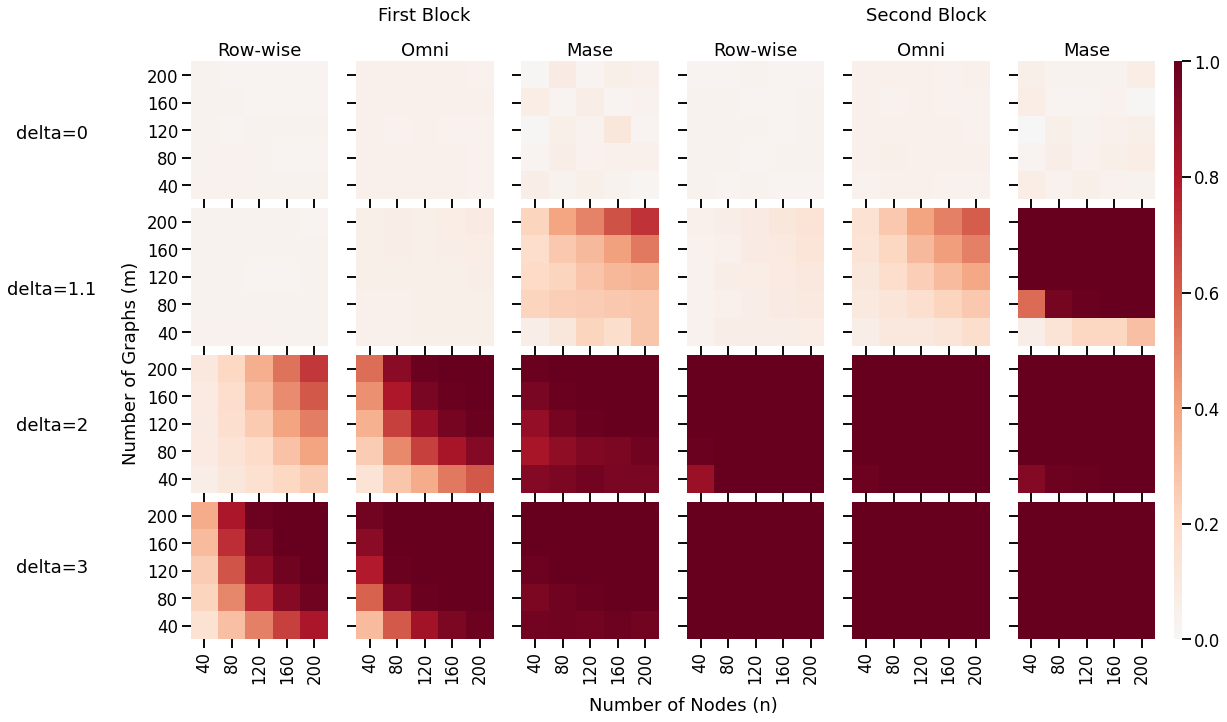

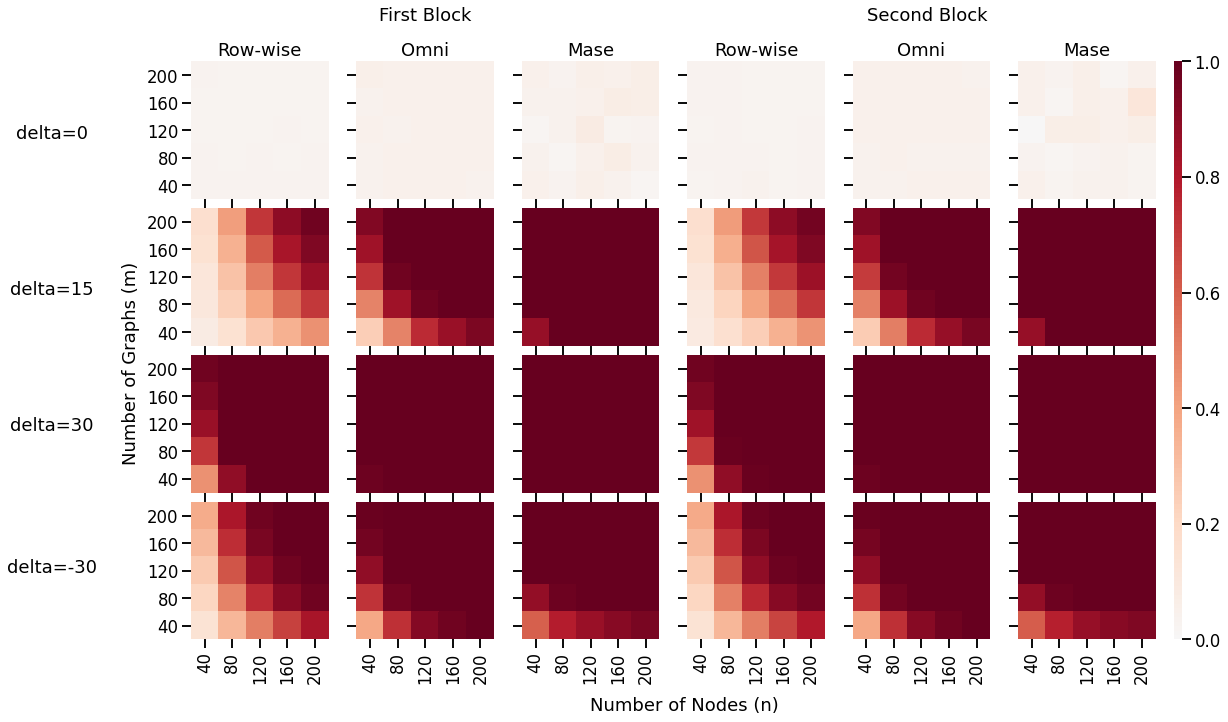

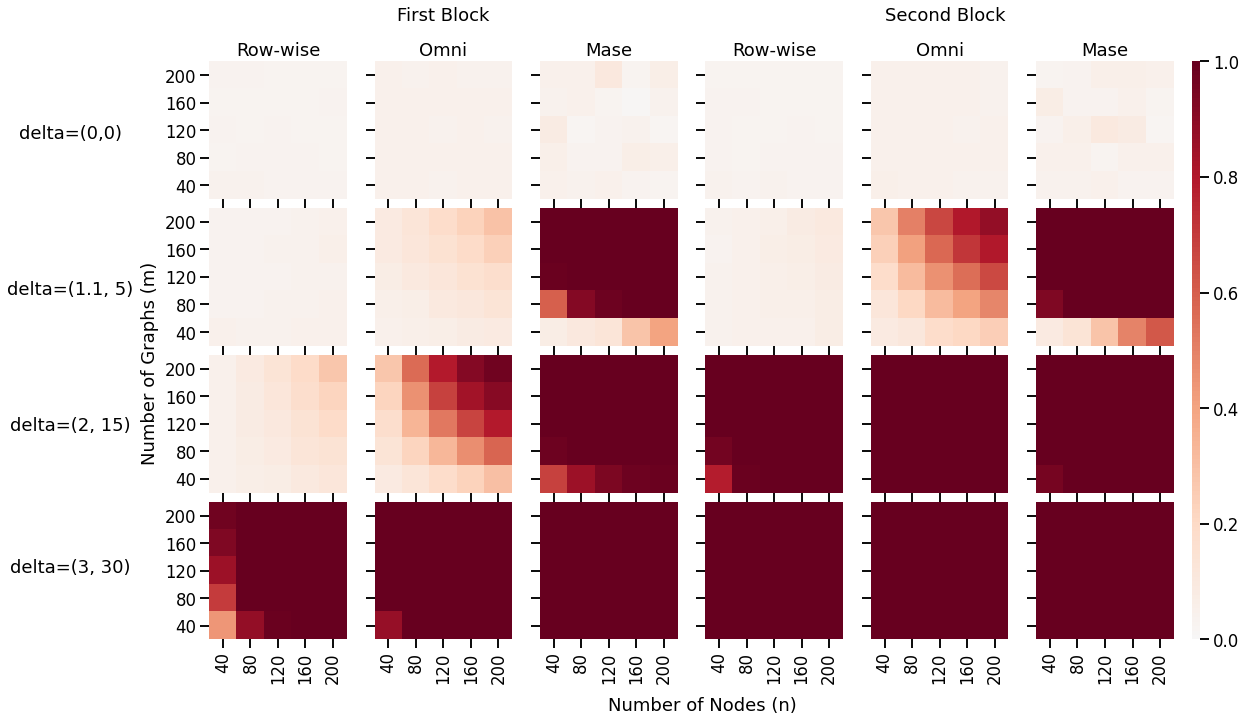

In [43]:
sns.set_context('talk')


for idx, model in enumerate(np.unique(dfs.model)):
    fig, ax = plt.subplots(
        4, 
        7, 
        figsize=(15, 9),
        sharex=True,
        sharey=True,
        constrained_layout=True,
        gridspec_kw={"width_ratios": [1, 1, 1, 1, 1, 1, 0.05]},
    )

    gs = ax[-1, -1].get_gridspec()
    for ax_ in ax[:, -1]:
        ax_.remove()
    ax_leg = fig.add_subplot(gs[:, -1])

    col_names = ["Row-wise", 'Omni', 'Mase']
    
    tmp_df = dfs[dfs.model == model]

    for row, effect_size in enumerate(pd.unique(tmp_df.effect_size)):
        for col, method in enumerate(tmp_df.columns[4:]):
            tmp = tmp_df[tmp_df.effect_size == effect_size][method]
            sns.heatmap(
                np.flipud(tmp.values.reshape(5, 5)),
                square=True,
                cmap='RdBu_r',
                center=0,
                cbar_ax=ax_leg,
                ax = ax[row, col],
                xticklabels=ns,
                yticklabels=ms[::-1],
                vmin=0,
                vmax=1
            )

            if row == 0:
                ax[row, col].set_title(col_names[col % 3])

    fig.text(0.26, 1.035, "First Block", va="center", ha="center")
    fig.text(0.725, 1.035, "Second Block", va="center", ha="center")

    if idx == 0:
        row_4 = "delta=3"
        row_3 = "delta=2"
        row_2 = "delta=1.1"
        row_1 = "delta=0"
    elif idx == 1:
        row_4 = "delta=-30"
        row_3 = "delta=30"
        row_2 = "delta=15"
        row_1 = "delta=0"
    elif idx == 2:
        row_4 = "delta=(3, 30)"
        row_3 = "delta=(2, 15)"
        row_2 = "delta=(1.1, 5)"
        row_1 = "delta=(0,0)"

    fig.text(-0.085, 0.175, row_4, ha="center")
    fig.text(-0.085, 0.395, row_3, ha="center")
    fig.text(-0.085, 0.605, row_2, ha="center")
    fig.text(-0.085, 0.845, row_1, ha="center")

    fig.text(0.5, -0.03, "Number of Nodes (n)", va="center", ha="center")
    fig.text(-0.02, 0.5, "Number of Graphs (m)", va="center", rotation="vertical")
    fig.savefig(f"./figures/rdpg_model_{model[-1]}.png", dpi=300, bbox_inches='tight')